# Rock Paper Scissor Classification from Webcam
Classify processed image-input of a hand from a **webcam** with a **convolutional neural network** into one of three classes: _"rock", "paper", "scissor"._

* https://keras.io/examples/vision/image_classification_from_scratch/
* https://www.tensorflow.org/tutorials/images/transfer_learning?hl=en

## Part 1: Classification with a Convolutional Neural Network

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### The Data
Import from local storage and split into training, validation and test set

In [75]:
image_size = (300, 300)
batch_size = 3
num_classes= 3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dat/rps",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dat/rps",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dat/rps-test-set",
    seed=1337,
    image_size=image_size,
    batch_size=32,
)

Found 2520 files belonging to 3 classes.
Using 2016 files for training.
Found 2520 files belonging to 3 classes.
Using 504 files for validation.
Found 372 files belonging to 3 classes.


Example Image:

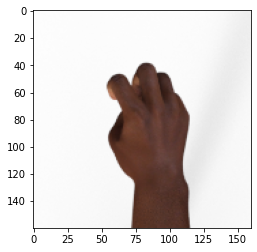

In [91]:
a = next(iter(train_ds.take(1)))
plt.imshow(a[0][0])

In [4]:
# n_train = 2016
# n_val   = 504
# n_test  = 372

### Data Augmentation Layer
Define a data augmentation layer which helps against overfitting and makes the model more robust. I use horizontal flips and a small rotation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

### Make Data fit
We'll be transfer training on the [MobileNetV2](https://arxiv.org/abs/1801.04381) Network, so the data needs to fit its input shape of $160\times 160 \times 3$, 

where $160 \times 160$ describes the image dimensions, and $3$ describes the three color channels RGB.

We also need to scale the intensity of the image by its maximum value (255)

In [76]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def normalize_img(image, label):
    return tf.image.resize(image, [160,160]) / 255., tf.one_hot(label, 3)

train_ds = train_ds.map(normalize_img, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(normalize_img, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(normalize_img, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

### CPU Data Augmentation
(No GPU on this work-computer)

In [10]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=AUTOTUNE)

### The Model
Defining the convolutional neural network

In [11]:
image_size = (160,160)
img_shape  = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

Set the MobileNetV2 layers to not be trained

In [12]:
base_model.trainable = False

Add our own dense layers ontop of the MobileNet

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Now Train!

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

initial_epochs = 10
history = model.fit(aug_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


Epoch 1/10
672/672 [==============================] - 52s 77ms/step - loss: 0.9806 - accuracy: 0.5689 - val_loss: 0.4236 - val_accuracy: 0.8611
Epoch 2/10
672/672 [==============================] - 48s 72ms/step - loss: 0.3834 - accuracy: 0.8760 - val_loss: 0.2546 - val_accuracy: 0.9286
Epoch 3/10
672/672 [==============================] - 47s 70ms/step - loss: 0.2424 - accuracy: 0.9291 - val_loss: 0.1868 - val_accuracy: 0.9464
Epoch 4/10
672/672 [==============================] - 50s 75ms/step - loss: 0.1728 - accuracy: 0.9534 - val_loss: 0.1542 - val_accuracy: 0.9544
Epoch 5/10
672/672 [==============================] - 47s 70ms/step - loss: 0.1373 - accuracy: 0.9618 - val_loss: 0.1258 - val_accuracy: 0.9603
Epoch 6/10
672/672 [==============================] - 52s 78ms/step - loss: 0.1145 - accuracy: 0.9722 - val_loss: 0.0904 - val_accuracy: 0.9782
Epoch 7/10
672/672 [==============================] - 51s 76ms/step - loss: 0.0960 - accuracy: 0.9697 - val_loss: 0.0987 - val_accuracy:

Show the training history

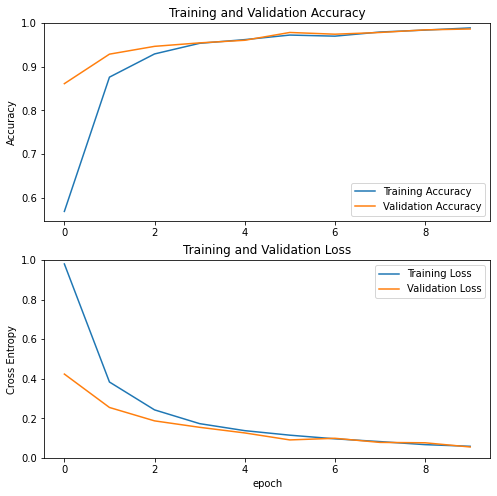

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Very Good performance on the test set!

In [45]:
loss, accuracy = model.evaluate(test_ds)

124/124 [==============================] - 8s 65ms/step - loss: 0.1404 - accuracy: 0.9462


Visualization of some test set images

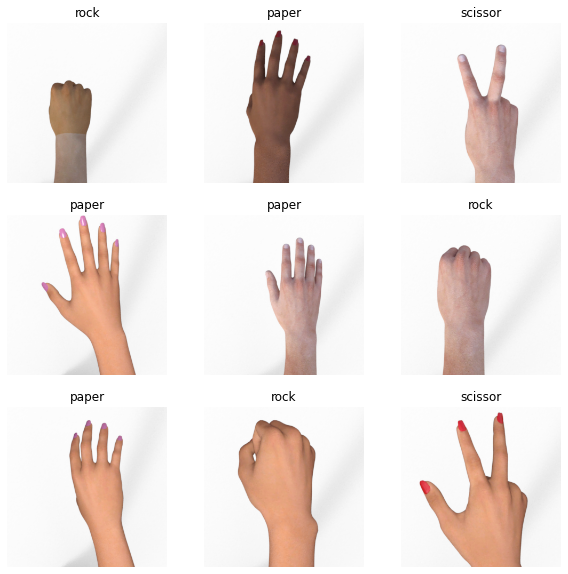

In [84]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
class_names = ['paper', 'rock', 'scissor']

predictions = tf.math.argmax(predictions.reshape((32,3), order='C'), axis=1)
label_batch = tf.math.argmax(label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = image_batch[i] * 255
    plt.imshow(img.astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")


In [87]:
model.save("models/rps_model")

INFO:tensorflow:Assets written to: /home/marc/Documents/rps_model/assets
